In [1]:
from pathlib import Path
import datetime

import gymnasium as gym
import torch

from policy_based import PolicyNetFunc, PolicyNetTrainer, PolicyNetTester
from deep_q import Discrete1ContinuousAction
from env import Env
from utils import clear_target_path, show_gif_on_jupyternb, to_gif

### Lab1 Policy-Base Train

使用CarPole-V1 环境，测试Policy-Based REINFORCE 算法

In [5]:
GYM_ENV_NAME = 'CartPole-v1'
_train_gym_env = gym.make(GYM_ENV_NAME)
env = Env(_train_gym_env)

# 打印查看环境的动作空间和状态空间 
action_nums, state_space = _train_gym_env.action_space.n, _train_gym_env.observation_space
print(f'action num: {action_nums}, space: {state_space}')

TRAIN_EPOCH = 1000
HIDDEN_DIM = 256
LEARNING_RATE = 2e-3
GAMMA = 0.99


LOG_PATH = Path('./run/logs/cartpoleV1/REINFORCE')
MODEL_PATH = Path('./run/model/cartpoleV1/REINFORCE.pth')
TEST_OUTPUT_PATH = Path('./run/test_result/cartpoleV1_REINFORCE')

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(state_space.shape[0], 
                   action_nums, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH)

action num: 2, space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


#### 训练模型

In [6]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
policy_func_trainer.train(train_epoch=TRAIN_EPOCH)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

policy_func.save(MODEL_PATH)

start training, now datetime: 2024-06-18 00:04:36.737850


100%|██████████| 1000/1000 [00:30<00:00, 32.41it/s, reward=195.00, step=195]

end training, saving model to: run\model\cartpoleV1\REINFORCE.pth, now datetime: 2024-06-18 00:05:07.600472


#### 开始测试

Test Reward: 192.0
Step Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


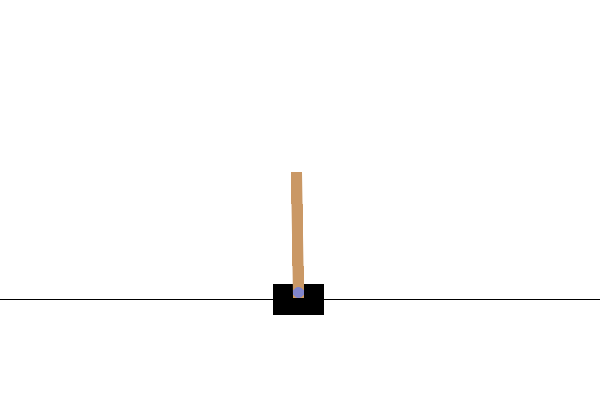

In [8]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func.to('cpu'),
    env=_render_env
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
policy_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)

### 使用Pendulum-v1 环境，测试Policy-Based REINFORCE 算法

In [2]:
GYM_ENV_NAME = 'Pendulum-v1'
RESULT_DIR_NAME = 'pendulumV1'

_train_gym_env = gym.make(GYM_ENV_NAME)
env = Env(_train_gym_env)

LOG_PATH = Path(f'./run/logs/{RESULT_DIR_NAME}/policy_based')
MODEL_PATH = Path(f'./run/model/{RESULT_DIR_NAME}/policy_model.pth')
TEST_OUTPUT_PATH = Path(f'./run/test_result/{RESULT_DIR_NAME}_policy')

# 打印查看环境的动作空间和状态空间 
action_space, state_space = _train_gym_env.action_space, _train_gym_env.observation_space
print(f'action: {action_space}, space: {state_space}')

# 动作空间离散化程度（用11个区间来替代连续动作空间）
BINS = 100

TRAIN_EPOCH = 10000
HIDDEN_DIM = 512
LEARNING_RATE = 1e-3
GAMMA = 0.99

_USE_CUDA = True and torch.cuda.is_available()
# _USE_CUDA = False and torch.cuda.is_available()

policy_func = PolicyNetFunc(state_space.shape[0], 
                   action_nums=BINS, 
                   hidden_dim=HIDDEN_DIM, 
                   device=torch.device('cuda') if _USE_CUDA else None)


policy_func_trainer = PolicyNetTrainer(policy_func=policy_func,
                                  env=env,
                                  learning_rate=LEARNING_RATE,
                                  gamma=GAMMA,
                                  logger_folder=LOG_PATH,
                                  action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS))

action: Box(-2.0, 2.0, (1,), float32), space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


#### 训练模型

In [3]:
clear_target_path(LOG_PATH)
clear_target_path(MODEL_PATH)
print(f'start training, now datetime: {datetime.datetime.now()}')
policy_func_trainer.train(train_epoch=TRAIN_EPOCH)
print(f'end training, saving model to: {MODEL_PATH}, now datetime: {datetime.datetime.now()}')

policy_func.save(MODEL_PATH)

start training, now datetime: 2024-06-17 23:58:54.934601


 26%|██▌       | 2601/10000 [03:10<09:02, 13.63it/s, reward=-1534.82, step=200]


KeyboardInterrupt: 

#### 开始测试

In [ ]:
test_policy_func = PolicyNetFunc.from_file(MODEL_PATH)
_render_env = Env(gym.make(GYM_ENV_NAME, render_mode='rgb_array_list'))
policy_func_tester = PolicyNetTester(
    policy_fun=test_policy_func.to('cpu'),
    env=_render_env,
    action_converter=Discrete1ContinuousAction(action_space.low, action_space.high, BINS)
)
RESULT_GIF = TEST_OUTPUT_PATH / 'result.gif'
clear_target_path(RESULT_GIF)
policy_func_tester.test(1000)
to_gif(_render_env._gym_env, RESULT_GIF, 1/30)

show_gif_on_jupyternb(RESULT_GIF)